### Prepping Data

In [53]:
import sys
sys.dont_write_bytecode = True

# uncomment load_ext line when you initially use the file, after you can comment to get rid of the warning that'll show up
%load_ext autoreload 
%autoreload 2

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from data_processing import prepData

path = '../data/bike.csv'
df = pd.read_csv(path, encoding_errors='ignore', parse_dates=['Date'], dayfirst=True)
pd.set_option('display.max_columns', None) # lets you scroll if your monitor isn't wide enough
df = prepData(df)
display(df)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


,Rented Bike Count,Temperature(C),Wind Speed(m/s),Solar Radiation(MJ/m2),Rainfall(mm),Spring,Summer,Autumn,Winter,Weekend,Summer*Temp
Date,,,,,,,,,,,
2017-12-01,9539,-2.454167,1.537500,1.16,0.0,0,0,0,1,0,-0.0
2017-12-02,8523,1.325000,1.712500,1.12,0.0,0,0,0,1,1,0.0
2017-12-03,7222,4.875000,1.612500,0.69,4.0,0,0,0,1,1,0.0
2017-12-04,8729,-0.304167,3.450000,1.17,0.1,0,0,0,1,0,-0.0
2017-12-05,8307,-4.458333,1.108333,0.64,0.0,0,0,0,1,0,-0.0
...,...,...,...,...,...,...,...,...,...,...,...
2018-11-26,17162,6.320833,1.029167,1.74,0.0,0,0,1,0,0,0.0
2018-11-27,16282,7.066667,1.350000,0.87,0.0,0,0,1,0,0,0.0
2018-11-28,16524,5.304167,1.695833,1.86,0.0,0,0,1,0,0,0.0


In [54]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import QuantileTransformer

y = df['Rented Bike Count'].to_numpy() # target value
X = df.drop('Rented Bike Count', axis=1) # taking out the target value

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = 0.7, shuffle=True, random_state=1)

y_transformer = QuantileTransformer(output_distribution='normal', random_state=1)
y_train = y_transformer.fit_transform(y_train.reshape(-1, 1)).ravel()
y_test = y_transformer.transform(y_test.reshape(-1, 1)).ravel()

c:\Users\oo\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\preprocessing\_data.py:2829: UserWarning: n_quantiles (1000) is greater than the total number of samples (247). n_quantiles is set to n_samples.
  warnings.warn(


## Model Selection
Going into this, there's a few models we can knock off our list
- We're targeting a numerical value so that means we'll need a regression model (minimizing mse and rmse, maximizing r2)
- We have some outliers and a little collinearity so it needs to handle those
- It has to be easily interpretable

In [43]:
from sklearn.tree import DecisionTreeRegressor, ExtraTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.svm import LinearSVR, NuSVR, SVR
from sklearn.linear_model import ARDRegression, ElasticNet, ElasticNetCV, HuberRegressor, Lars, LarsCV, Lasso, LassoCV, LassoLarsCV, LassoLarsIC, LinearRegression
from sklearn.linear_model import QuantileRegressor, RANSACRegressor, Ridge, RidgeCV, SGDRegressor, BayesianRidge
from sklearn.linear_model import TheilSenRegressor, TweedieRegressor
from sklearn.ensemble import ExtraTreesRegressor, GradientBoostingRegressor,  HistGradientBoostingRegressor, RandomForestRegressor

### 'Kitchen Sink' Selection
Testing default values from most regression models in the sklearn library.
<br>From there, doing research and looking at metrics to select a model

In [44]:
from sklearn.model_selection import KFold, cross_val_score # for training a model
from sklearn.metrics import mean_squared_error, r2_score # for finding r2 and MSE
from IPython.display import clear_output

cv = KFold(n_splits=5, shuffle=True, random_state=1) # for cross validation

all_model = { # random_state=1 for reproductability
    'DecisionTree' : DecisionTreeRegressor(random_state=1),
    'ExtraTree' : ExtraTreeRegressor(random_state=1),
    'KNeighbors' : KNeighborsRegressor(),
    'KernelRidge' : KernelRidge(),
    'LinearSVR' : LinearSVR(random_state=1),
    'SVR' : SVR(),
    'NuSVR' : NuSVR(),
    'ARDRegression' : ARDRegression(),
    'ElasticNet' : ElasticNet(random_state=1),
    'ElasticNetCV' : ElasticNetCV(random_state=1),
    'HuberRegressor' : HuberRegressor(),
    'Lars' : Lars(random_state=1),
    'LarsCV' : LarsCV(),
    'Lasso' : Lasso(random_state=1),
    'LassoCV' : LassoCV(random_state=1),
    'LassoLarsCV' : LassoLarsCV(),
    'LassoLarsIC' : LassoLarsIC(),
    'LinearRegression' : LinearRegression(),
    'QuantileRegressor' : QuantileRegressor(),
    'RANSACRegressor' : RANSACRegressor(random_state=1),
    'Ridge' : Ridge(random_state=1),
    'RidgeCV' : RidgeCV(),
    'SGDRegressor' : SGDRegressor(random_state=1),
    'BayesianRidge' : BayesianRidge(),
    'TheilSenRegressor' : TheilSenRegressor(random_state=1),
    'TweedieRegressor' : TweedieRegressor(),
    'ExtraTreesRegressor' : ExtraTreesRegressor(random_state=1),
    'GradientBoostingRegressor' : GradientBoostingRegressor(random_state=1),
    'HistGradientBoostingRegressor' : HistGradientBoostingRegressor(random_state=1),
    'RandomForestRegressor' : RandomForestRegressor(random_state=1)
    }

screening = [] # our output

for name, model in all_model.items():
    print(name) # for debugging

    reg = model.fit(X_train, y_train)
    train_pred = reg.predict(X_train)
    test_pred = reg.predict(X_test)
    
    # convert our predictions back into normal space
    pred_train_original = y_transformer.inverse_transform(train_pred.reshape(-1,1))
    pred_test_original = y_transformer.inverse_transform(test_pred.reshape(-1,1))
    y_train_original = y_transformer.inverse_transform(y_train.reshape(-1,1))
    y_test_original = y_transformer.inverse_transform(y_test.reshape(-1,1))
    
    # gathering metrics
    cv_r2_score = round(np.mean(cross_val_score(reg, X_train, y_train, cv=cv, scoring='r2')), 2)
    r2_train = round(r2_score(y_train_original, pred_train_original), 2)
    r2_test = round(r2_score(y_test_original, pred_test_original), 2)
    mse_train = round(mean_squared_error(y_train_original, pred_train_original), 2)
    mse_test = round(mean_squared_error(y_test_original, pred_test_original), 2)
    rmse = np.sqrt(mse_test)
    screening.append([name, r2_test, r2_train, mse_test, mse_train, rmse, cv_r2_score])

# converting output to a dataframe and adding column names
screening_df = pd.DataFrame(screening, columns=('model', 'r2_test', 'r2_train', 'mse_test', 'mse_train', 'rmse', 'cv_r2_score'))

# makes it easier to find overfitting, should be positive
screening_df['r2_diff'] = screening_df['r2_test'] - screening_df['r2_train']

# makes it easier to find overfitting, should be negative
screening_df['mse_diff'] = screening_df['mse_test'] - screening_df['mse_train']

clear_output(True) # clean up output
display(screening_df.sort_values(['r2_test', 'r2_diff'], ascending=False))

,model,r2_test,r2_train,mse_test,mse_train,rmse,cv_r2_score,r2_diff,mse_diff
26,ExtraTreesRegressor,0.93,1.00,6.762211e+06,0.000000e+00,2600.425079,8.000000e-01,-0.07,6762210.59
28,HistGradientBoostingRegressor,0.91,0.97,8.470920e+06,3.307706e+06,2910.484513,7.700000e-01,-0.06,5163214.19
29,RandomForestRegressor,0.90,0.98,9.337810e+06,1.515894e+06,3055.783111,8.100000e-01,-0.08,7821916.21
3,KernelRidge,0.88,0.90,1.180073e+07,1.029512e+07,3435.219101,8.000000e-01,-0.02,1505613.30
14,LassoCV,0.88,0.90,1.194210e+07,1.022019e+07,3455.734831,8.100000e-01,-0.02,1721914.03
20,Ridge,0.88,0.90,1.185817e+07,1.027923e+07,3443.569267,8.000000e-01,-0.02,1578942.01
27,GradientBoostingRegressor,0.88,0.98,1.189935e+07,2.341146e+06,3449.542813,8.300000e-01,-0.10,9558199.25
9,ElasticNetCV,0.87,0.87,1.251420e+07,1.271865e+07,3537.541943,7.400000e-01,0.00,-204450.19
7,ARDRegression,0.87,0.90,1.289825e+07,9.639577e+06,3591.412765,8.200000e-01,-0.03,3258668.98
10,HuberRegressor,0.87,0.90,1.263449e+07,9.504661e+06,3554.502533,8.200000e-01,-0.03,3129827.21


In [45]:
# finding models that have similar r2 for train and test and have good values
display(screening_df.loc[(screening_df['r2_diff']>=-0.15) & (screening_df['r2_test']>=0.70)].sort_values(['r2_diff', 'rmse'], ascending=[False, True]))

,model,r2_test,r2_train,mse_test,mse_train,rmse,cv_r2_score,r2_diff,mse_diff
25,TweedieRegressor,0.80,0.79,19195389.87,20568154.05,4381.254372,0.64,0.01,-1372764.18
8,ElasticNet,0.77,0.76,22007645.34,23919270.69,4691.230685,0.60,0.01,-1911625.35
13,Lasso,0.77,0.76,22227451.74,24024365.34,4714.599849,0.60,0.01,-1796913.60
9,ElasticNetCV,0.87,0.87,12514203.00,12718653.19,3537.541943,0.74,0.00,-204450.19
3,KernelRidge,0.88,0.90,11800730.27,10295116.97,3435.219101,0.80,-0.02,1505613.30
20,Ridge,0.88,0.90,11858169.30,10279227.29,3443.569267,0.80,-0.02,1578942.01
14,LassoCV,0.88,0.90,11942103.22,10220189.19,3455.734831,0.81,-0.02,1721914.03
18,QuantileRegressor,0.71,0.73,27896775.84,27134306.62,5281.739850,0.53,-0.02,762469.22
10,HuberRegressor,0.87,0.90,12634488.26,9504661.05,3554.502533,0.82,-0.03,3129827.21
21,RidgeCV,0.87,0.90,12784907.12,9606328.39,3575.598848,0.83,-0.03,3178578.73


In [46]:
display(screening_df.iloc[10])

model          HuberRegressor
r2_test                  0.87
r2_train                  0.9
mse_test          12634488.26
mse_train          9504661.05
rmse              3554.502533
cv_r2_score              0.82
r2_diff                 -0.03
mse_diff           3129827.21
Name: 10, dtype: object

## Model we'll be working with
HuberRegressor
- Linear regression model (easily interpretable)
- Uses L2 regularization (reduce overfitting, handle multicollinearity)
- Unique loss function (robust to outliers)

## Part 2: Tuning hyperparameters
- n_jobs=* declares how many processors your computer will use; -1 uses all. Change at your own risk
<p>If a hyperparameter isn't listed for a model then it doesn't have a significant effect on its performance (based off my testing (byron))

In [55]:
param_dict = {
    'HuberRegressor' : {
        'epsilon' : [1.0, 1.35, 2.0],
        'alpha': [3, 4, 5, 6]}
}

model_dict = {
    'HuberRegressor' : HuberRegressor(max_iter=1000)}

### Bayesian Optimization

In [48]:
from skopt import BayesSearchCV
from skopt.space import Categorical, Integer, Real
import copy
from sklearn.exceptions import ConvergenceWarning
import warnings
import time
from mlxtend.evaluate import bias_variance_decomp

# common warning because bayesian search tries not to redo configurations when picking random ones
warnings.filterwarnings("ignore", message="The objective has been evaluated at point")

# bayes might try a small number of iterations, better to ignore this warning than see it 10 billion times because it cant converge
warnings.filterwarnings("ignore", category=ConvergenceWarning)

# only run the specified models and pick the top n by their r2 
def baye_searcher(models_to_run, top_n=30):
    summary = [] # our output

    for name, model in model_dict.items(): # iterate through all available models
        if name not in models_to_run:  # only uses the selected models
            continue

        start_time = time.time() # for tracking time
        print(f"Now working on {name}")

        # BayesSearch uses search spaces instead of param grids so we have to convert
        search_space = copy.deepcopy(param_dict[name])
        for param, values, in search_space.items():
            if isinstance(values[0], str):
                search_space[param] = tuple(values)
            if isinstance(values[0], bool):
                search_space[param] = Categorical(categories=(False, True))
            if isinstance(values[0], int):
                search_space[param] = Integer(min(values), max(values))
            if isinstance(values[0], float):
                search_space[param] = Real(min(values), max(values))

        # finds the best model configuration to maximize R2
        b_search = BayesSearchCV(estimator=model, search_spaces=search_space, cv=cv, random_state=1, scoring='r2', return_train_score=True, n_jobs=-1, n_iter=top_n, n_points=4)
        b_search.fit(X_train, y_train)

        # upload all configuration scores into dataframe and grab only the top n performing that have the least overfitting
        results = pd.DataFrame(b_search.cv_results_)
        results['r2_diff'] = results['mean_test_score'] - results['mean_train_score']
        results = results.sort_values('r2_diff', ascending=False)

        for i, row in results.iterrows(): # iterate through top n configurations
            params = row['params']
            best_model = model.set_params(**params)  # refit model to the current parameters
            try:
                best_model.fit(X_train, y_train)
            except Exception as e:
                print(f"Skipping {params} due to {e}")
                continue
            # these are here so we can dynamically add as many columns as there are params and values
            param_keys = list(params.keys())
            param_values = list(params.values())

            train_pred = best_model.predict(X_train)
            test_pred = best_model.predict(X_test)

            # convert our predictions back into normal space
            pred_train_original = y_transformer.inverse_transform(train_pred.reshape(-1,1))
            pred_test_original = y_transformer.inverse_transform(test_pred.reshape(-1,1))
            y_train_original = y_transformer.inverse_transform(y_train.reshape(-1,1))
            y_test_original = y_transformer.inverse_transform(y_test.reshape(-1,1))

            # gathering metrics
            r2_train = round(r2_score(y_train_original, pred_train_original), 3)
            r2_test = round(r2_score(y_test_original, pred_test_original), 3)
            mse_train = round(mean_squared_error(y_train_original, pred_train_original), 3)
            mse_test = round(mean_squared_error(y_test_original, pred_test_original), 3)
            rmse = np.sqrt(mse_test)
            try:
                loss, bias, var = bias_variance_decomp(
                    best_model, X_train.to_numpy(), y_train, X_test.to_numpy(), y_test, loss='mse', random_seed=1)
            except Exception as e:
                print(f"Skipping {params} due to {e}")
                continue
            summary.append([name, param_keys, param_values, r2_test, r2_train, mse_test, mse_train, loss, bias, var, rmse])
        end_time = time.time()
        print(f"{name} took {end_time - start_time:.2f} seconds")

    # converting output to a dataframe and adding column names
    summary_df = pd.DataFrame(summary, columns=('model', 'param_names', 'param_values', 'r2_test', 'r2_train', 'mse_test', 'mse_train', 'loss', 'bias', 'vari', 'rmse'))

    # makes it easier to find overfitting, should be positive
    summary_df['r2_diff'] = summary_df['r2_test'] - summary_df['r2_train']

    # makes it easier to find overfitting, should be negative
    summary_df['mse_diff'] = summary_df['mse_test'] - summary_df['mse_train']

    # find the max number of parameters for all the models
    max_params = max(summary_df['param_names'].apply(len))

    # dynamically adding as many columns as there are params and values; also padding with placeholders in case different models dont have the same number
    summary_df['param_names'] = summary_df['param_names'].apply(lambda x: x + ["Missing"] * (max_params - len(x)))
    summary_df['param_values'] = summary_df['param_values'].apply(lambda x: x + ["Missing"] * (max_params - len(x)))

    # insert param names and values
    for i in range(max_params):
        summary_df[f'param{i+1}'] = summary_df['param_names'].apply(lambda x: x[i])
        summary_df[f'val{i+1}'] = summary_df['param_values'].apply(lambda x: x[i])

    # Drop original columns
    summary_df = summary_df.drop(columns=['param_names', 'param_values'])

    return summary_df

### Grid Search
Tries every possible hyperparameter configuration in our parameter grid

In [49]:
from sklearn.model_selection import GridSearchCV
from itertools import product

# only run the specified models and pick the top n by their r2 diff
def grid_searcher(models_to_run, top_n=-1):
    summary = [] # output holder

    for name, model in model_dict.items(): # iterate through all available models
        if name not in models_to_run:  # only uses the selected models
            continue
        
        num_combinations = len(list(product(param_dict[name])))
        if top_n < 1: top_n = num_combinations # if no number of results is specified, gather all results (every combination)
        if top_n > num_combinations: top_n = len(list(product(param_dict[name]))) # if too many results are specifed, only get the max
        
        start_time = time.time() # for tracking time
        print(f"Now working on {name}")
        
        # finds the best model configuration to maximize R2
        grid_search = GridSearchCV(estimator=model, param_grid=param_dict[name], scoring='r2', cv=cv, n_jobs=-1, return_train_score=True)
        grid_search.fit(X_train, y_train)

        # upload all configuration scores into dataframe and grab only the top n performing that have the least overfitting
        results = pd.DataFrame(grid_search.cv_results_)
        results['r2_diff'] = results['mean_test_score'] - results['mean_train_score']
        results = results.sort_values('r2_diff', ascending=False).head(top_n)

        for i, row in results.iterrows(): # iterate through top n configurations
            params = row['params']
            best_model = model.set_params(**params)  # refit model to the current parameters
            try:
                best_model.fit(X_train, y_train)
            except Exception as e:
                print(f"Skipping {params} due to {e}")
                continue
            # these are here so we can dynamically add as many columns as there are params and values
            param_keys = list(params.keys())
            param_values = list(params.values())
        
            train_pred = best_model.predict(X_train)
            test_pred = best_model.predict(X_test)

            # convert our predictions back into normal space
            pred_train_original = y_transformer.inverse_transform(train_pred.reshape(-1,1))
            pred_test_original = y_transformer.inverse_transform(test_pred.reshape(-1,1))
            y_train_original = y_transformer.inverse_transform(y_train.reshape(-1,1))
            y_test_original = y_transformer.inverse_transform(y_test.reshape(-1,1))

            # gathering metrics
            r2_train = round(r2_score(y_train_original, pred_train_original), 3)
            r2_test = round(r2_score(y_test_original, pred_test_original), 3)
            mse_train = round(mean_squared_error(y_train_original, pred_train_original), 3)
            mse_test = round(mean_squared_error(y_test_original, pred_test_original), 3)
            rmse = np.sqrt(mse_test)
            try:
                loss, bias, var = bias_variance_decomp(
                    best_model, X_train.to_numpy(), y_train, X_test.to_numpy(), y_test, loss='mse', random_seed=1)
            except Exception as e:
                print(f"Skipping {params} due to {e}")
                continue
            summary.append([name, param_keys, param_values, r2_test, r2_train, mse_test, mse_train, loss, bias, var, rmse])
        end_time = time.time()
        print(f"{name} took {end_time - start_time:.2f} seconds")

    # adding column names
    summary_df = pd.DataFrame(summary, columns=('model', 'param_names', 'param_values', 'r2_test', 'r2_train', 'mse_test', 'mse_train', 'loss', 'bias', 'vari', 'rmse'))

    # makes it easier to find overfitting, should be positive
    summary_df['r2_diff'] = summary_df['r2_test'] - summary_df['r2_train']

    # makes it easier to find overfitting, should be negative
    summary_df['mse_diff'] = summary_df['mse_test'] - summary_df['mse_train']

    # find the max number of parameters for all the models
    max_params = max(summary_df['param_names'].apply(len))

    # dynamically adding as many columns as there are params and values; also padding with placeholders in case different models dont have the same number
    summary_df['param_names'] = summary_df['param_names'].apply(lambda x: x + ["Missing"] * (max_params - len(x)))
    summary_df['param_values'] = summary_df['param_values'].apply(lambda x: x + ["Missing"] * (max_params - len(x)))

    # insert param names and values
    for i in range(max_params):
        summary_df[f'param{i+1}'] = summary_df['param_names'].apply(lambda x: x[i])
        summary_df[f'val{i+1}'] = summary_df['param_values'].apply(lambda x: x[i])

    # drop original columns
    summary_df = summary_df.drop(columns=['param_names', 'param_values'])

    return summary_df

In [51]:
tune1_results = baye_searcher(['HuberRegressor'], 300)

Now working on HuberRegressor
HuberRegressor took 5154.39 seconds


In [52]:
tune1_2 = grid_searcher(['HuberRegressor'])
tune1_results = pd.concat([tune1_results, tune1_2], axis=0)

Now working on HuberRegressor
Skipping {'alpha': 3, 'epsilon': 1.0} due to HuberRegressor convergence failed: l-BFGS-b solver terminated with ABNORMAL: 
Skipping {'alpha': 5, 'epsilon': 1.0} due to HuberRegressor convergence failed: l-BFGS-b solver terminated with ABNORMAL: 
HuberRegressor took 16.60 seconds


ValueError: max() iterable argument is empty

In [56]:
display(tune1_results.loc[(tune1_results['r2_diff']>=-0.005) & (tune1_results['r2_test']>=0.8) & (tune1_results['rmse']<3400)].sort_values('rmse', ascending=True))

,model,r2_test,r2_train,mse_test,mse_train,loss,bias,vari,rmse,r2_diff,mse_diff,param1,val1,param2,val2
148,HuberRegressor,0.889,0.892,1.060873e+07,1.074837e+07,0.229536,0.206200,0.023336,3257.104120,-0.003,-139641.166,alpha,5,epsilon,1.668503
159,HuberRegressor,0.889,0.892,1.061573e+07,1.073490e+07,0.229895,0.206693,0.023202,3258.179263,-0.003,-119168.504,alpha,5,epsilon,1.715500
163,HuberRegressor,0.889,0.892,1.063548e+07,1.073262e+07,0.230038,0.206867,0.023171,3261.207952,-0.003,-97144.985,alpha,5,epsilon,1.730865
124,HuberRegressor,0.889,0.892,1.064239e+07,1.075091e+07,0.229529,0.205692,0.023837,3262.267537,-0.003,-108521.348,alpha,5,epsilon,1.583963
139,HuberRegressor,0.889,0.892,1.064297e+07,1.075751e+07,0.229430,0.205988,0.023443,3262.356155,-0.003,-114540.032,alpha,5,epsilon,1.644197
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
53,HuberRegressor,0.883,0.879,1.125556e+07,1.206870e+07,0.260627,0.226087,0.034540,3354.930824,0.004,-813136.855,alpha,6,epsilon,1.007084
61,HuberRegressor,0.882,0.881,1.131009e+07,1.186250e+07,0.247944,0.217031,0.030913,3363.047153,0.001,-552413.112,alpha,6,epsilon,1.101480
4,HuberRegressor,0.882,0.883,1.134230e+07,1.161550e+07,0.245874,0.213633,0.032241,3367.833124,-0.001,-273203.918,alpha,5,epsilon,1.037668
3,HuberRegressor,0.882,0.883,1.134271e+07,1.161746e+07,0.245851,0.213606,0.032245,3367.893573,-0.001,-274755.336,alpha,5,epsilon,1.037708


## Tuned Model

In [8]:
def test_model(model):
    model.fit(X_train, y_train)

    train_pred = model.predict(X_train)
    test_pred = model.predict(X_test)

    # convert our predictions back into normal space
    train_pred_original = y_transformer.inverse_transform(train_pred.reshape(-1,1))
    test_pred_original = y_transformer.inverse_transform(test_pred.reshape(-1,1))
    y_train_original = y_transformer.inverse_transform(y_train.reshape(-1,1))
    y_test_original = y_transformer.inverse_transform(y_test.reshape(-1,1))

    # gathering metrics
    r2_train = r2_score(y_train_original, train_pred_original)
    r2_test = r2_score(y_test_original, test_pred_original)
    mse_test = mean_squared_error(y_test_original, test_pred_original)
    rmse = np.sqrt(mse_test)

    # printing results
    print(f"Test Accuracy: {r2_test * 100:.2f}%")
    print(f"Train Accuracy: {r2_train * 100:.2f}%")
    print(f"Accuracy Difference: {(r2_test - r2_train) * 100:.2f}%")
    print(f"Test Mean Squared Error: {mse_test:.2f}")
    print(f"Root Mean Squared Error: {rmse:.2f}")

    # visualizing
    fig, ax = plt.subplots(1, 3, figsize=(20,7))
    plt.suptitle('')
    ax[0].set_title('Predicted vs Actual for Test Set')
    ax[0].scatter(y_test_original, test_pred_original, color='blue', label='Predicted vs Actual')
    ax[0].plot(y_test_original, y_test_original, color='red', label='Ideal')
    ax[0].legend()
    ax[0].set_xlabel('Actual')
    ax[0].set_ylabel('Predicted')

    ax[1].set_title('Predicted vs Actual for Train Set')
    ax[1].scatter(y_train_original, train_pred_original, color='green', label='Predicted vs Actual')
    ax[1].plot(y_train_original, y_train_original, color='red', label='Ideal')
    ax[1].legend()
    ax[1].set_xlabel('Actual')
    ax[1].set_ylabel('Predicted')

    residuals = y_test_original.reshape(-1,1) - test_pred_original.reshape(-1,1)
    ax[2].set_title('Residual Plot for Test Set')
    ax[2].scatter(test_pred_original, residuals, color='blue')
    ax[2].axhline(y=0, color='red', linestyle='--', label='Zero Residual Line')
    ax[2].legend()
    ax[2].set_xlabel("Fitted")
    ax[2].set_ylabel("Residuals")

    plt.show()

Test Accuracy: 88.95%
Train Accuracy: 89.19%
Accuracy Difference: -0.24%
Test Mean Squared Error: 10605637.91
Root Mean Squared Error: 3256.63


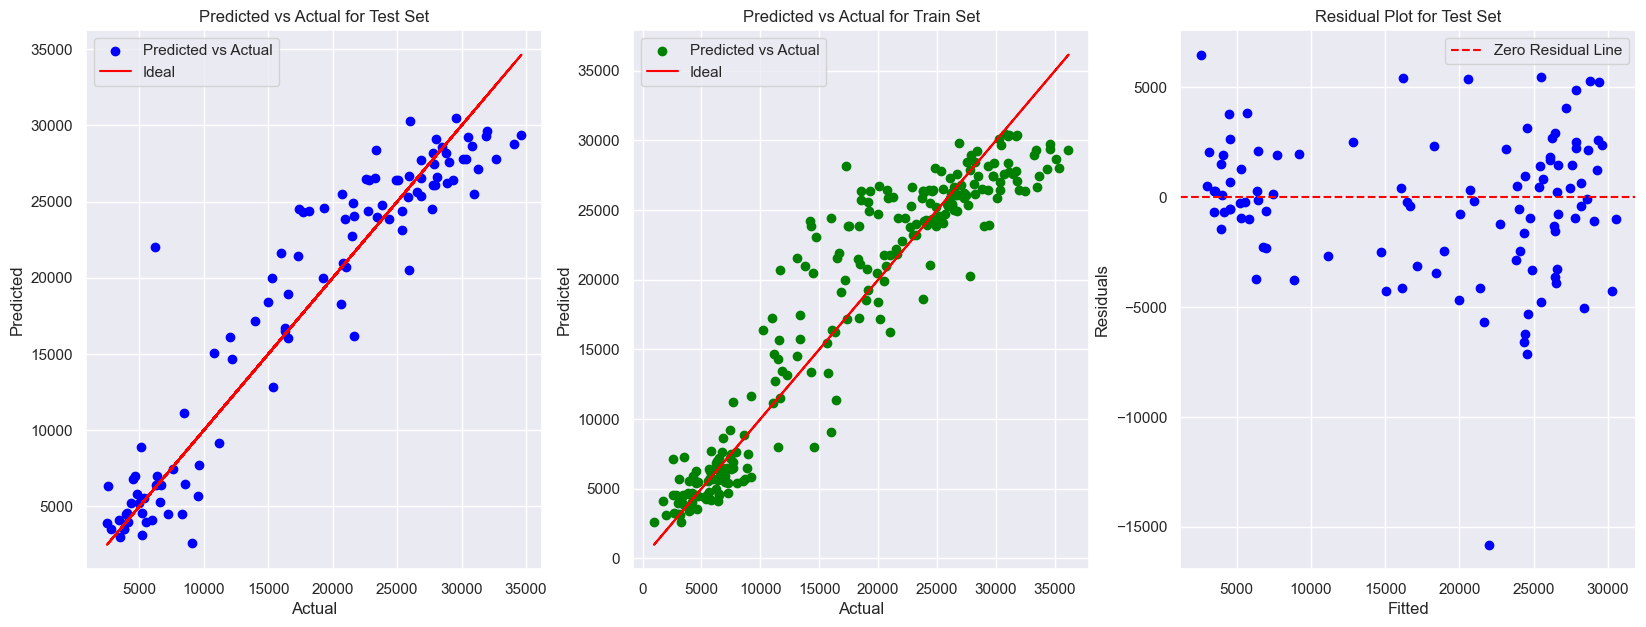

In [57]:
hub_model = HuberRegressor(alpha=5, epsilon=1.668503, max_iter=1000)
test_model(hub_model)

## Final Model

Stacking it with Ridge seems to work the best so that's our final model

In [21]:
def finalTest(model):
    model.fit(X_train, y_train)

    train_pred = model.predict(X_train)
    test_pred = model.predict(X_test)

    # creating the regression equation
    feature_names = X_train.columns
    coefs = model.coef_

    reg_equation = f"QuantileTransformation(BikeCount) = {model.intercept_:.2f}"
    for i, coef in enumerate(coefs):
        if coef > 0:
            reg_equation += f' + {coef:.2f}*{feature_names[i]}'
        else:
            reg_equation += f' - {abs(coef):.2f}*{feature_names[i]}'
            
    # convert our predictions back into normal space
    train_pred_original = y_transformer.inverse_transform(train_pred.reshape(-1,1))
    test_pred_original = y_transformer.inverse_transform(test_pred.reshape(-1,1))
    y_train_original = y_transformer.inverse_transform(y_train.reshape(-1,1))
    y_test_original = y_transformer.inverse_transform(y_test.reshape(-1,1))

    # gathering metrics    
    r2_train = r2_score(y_train_original, train_pred_original)
    r2_test = r2_score(y_test_original, test_pred_original)
    mse_test = mean_squared_error(y_test_original, test_pred_original)
    mse_train = mean_squared_error(y_train_original, train_pred_original)
    rmse_test = np.sqrt(mse_test)
    rmse_train = np.sqrt(mse_train)

    clear_output(True)
    print(f"Regression Equation:\n{reg_equation}")
    print(f"Test Accuracy: {r2_test * 100:.2f}%")
    print(f"Train Accuracy: {r2_train * 100:.2f}%")
    print(f"Accuracy Difference: {(r2_test - r2_train) * 100:.2f}%")
    print(f"Test Mean Squared Error: {mse_test:.2f}")
    print(f"Train Mean Squared Error: {mse_train:.2f}")
    print(f"Test Root Mean Squared Error: {rmse_test:.2f}")
    print(f"Train Root Mean Squared Error: {rmse_train:.2f}")

    # Visualizing
    sns.set_theme(style='darkgrid')
    fig, ax = plt.subplots(2, 2, figsize=(20,13))
    ax[0,0].set_title('Predicted vs Actual for Test Set')
    ax[0,0].scatter(y_test_original, test_pred_original, color='blue', label='Predicted vs Actual')
    ax[0,0].plot(y_test_original, y_test_original, color='red', label='Ideal')
    ax[0,0].legend()
    ax[0,0].set_xlabel('Actual')
    ax[0,0].set_ylabel('Predicted')

    ax[0,1].set_title('Predicted vs Actual for Train Set')
    ax[0,1].scatter(y_train_original, train_pred_original, color='green', label='Predicted vs Actual')
    ax[0,1].plot(y_train_original, y_train_original, color='red', label='Ideal')
    ax[0,1].legend()
    ax[0,1].set_xlabel('Actual')
    ax[0,1].set_ylabel('Predicted')

    test_residuals = y_test_original.reshape(-1,1) - test_pred_original.reshape(-1,1)
    ax[1,0].set_title('Residual Plot for Test Set')
    ax[1,0].scatter(test_pred_original, test_residuals, color='blue')
    ax[1,0].axhline(y=0, color='red', linestyle='--', label='Zero Residual Line')
    ax[1,0].legend()
    ax[1,0].set_xlabel("Fitted")
    ax[1,0].set_ylabel("Residuals")

    train_residuals = y_train_original.reshape(-1,1) - train_pred_original.reshape(-1,1)
    ax[1,1].set_title('Residual Plot for Train Set')
    ax[1,1].scatter(train_pred_original, train_residuals, color='green')
    ax[1,1].axhline(y=0, color='red', linestyle='--', label='Zero Residual Line')
    ax[1,1].legend()
    ax[1,1].set_xlabel("Fitted")
    ax[1,1].set_ylabel("Residuals")
    
    plt.show()

Regression Equation:
QuantileTransformation(BikeCount) = -0.38 + 0.06*Temperature(C) - 0.06*Wind Speed(m/s) + 0.27*Solar Radiation(MJ/m2) - 0.03*Rainfall(mm) - 0.61*Spring + 1.58*Summer - 0.28*Autumn - 0.69*Winter - 0.24*Weekend - 0.09*Summer*Temp
Test Accuracy: 88.95%
Train Accuracy: 89.19%
Accuracy Difference: -0.24%
Test Mean Squared Error: 10605637.91
Train Mean Squared Error: 10750063.47
Test Root Mean Squared Error: 3256.63
Train Root Mean Squared Error: 3278.73


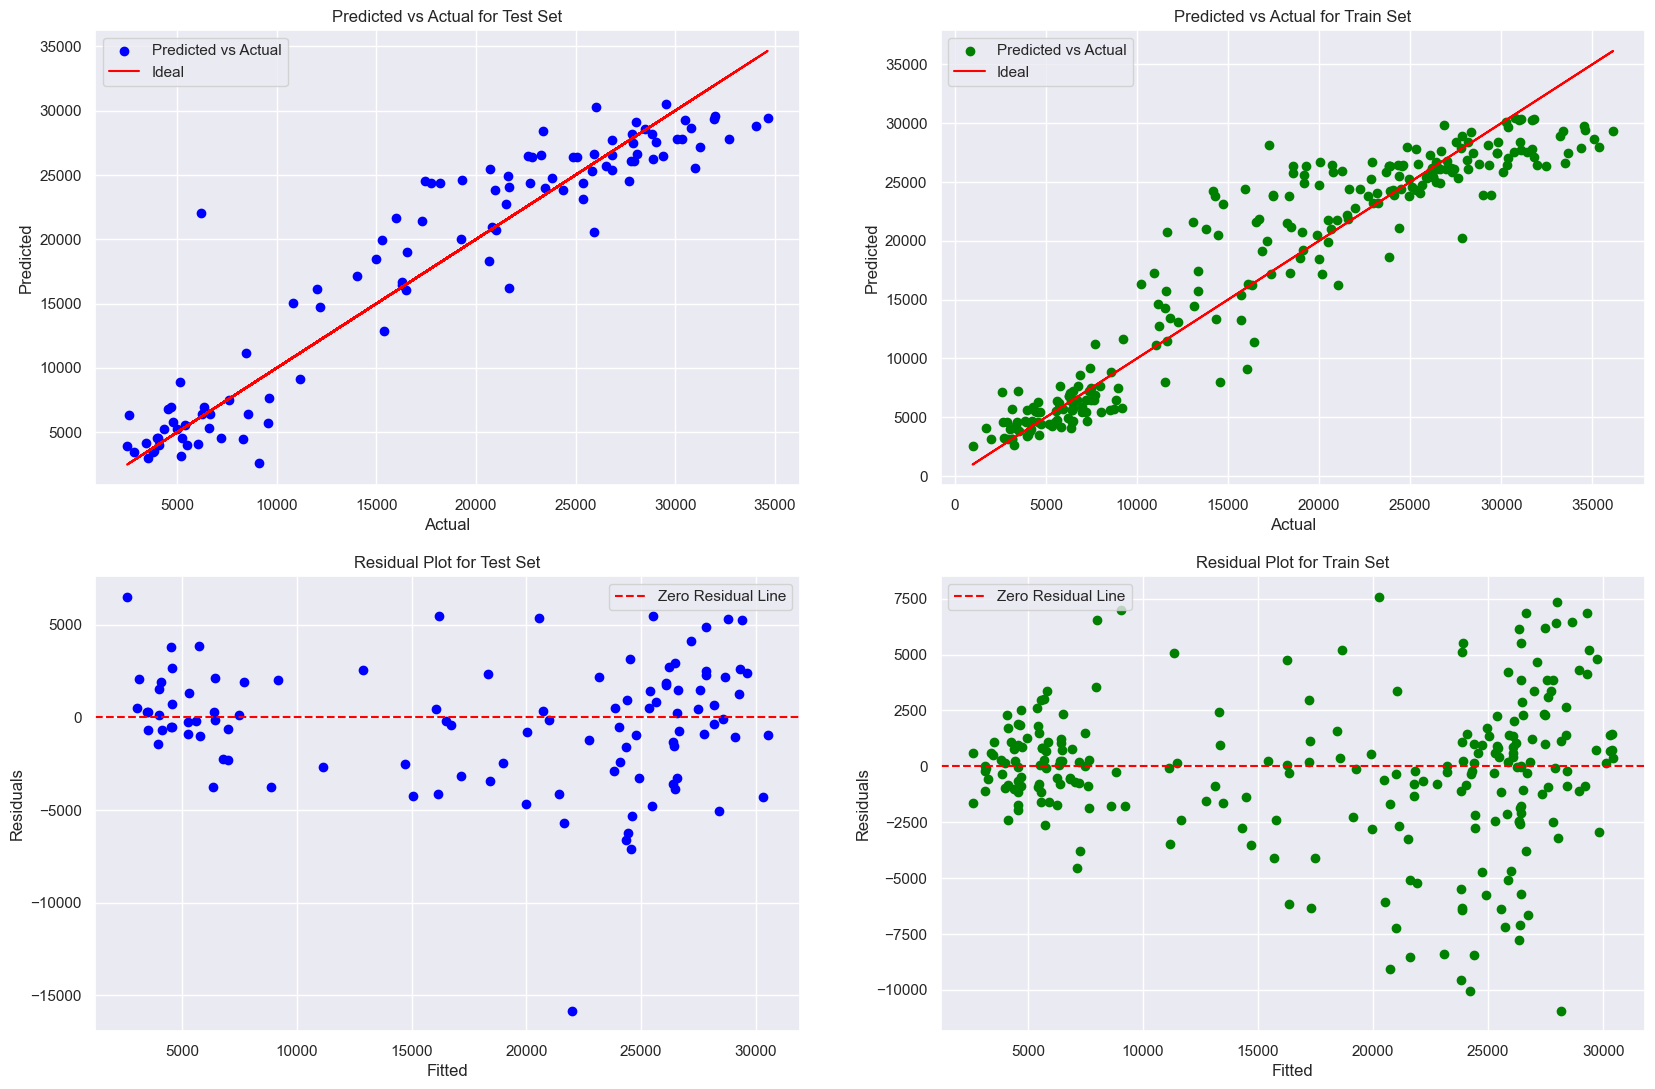

In [58]:
finalTest(hub_model)